[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yasharthy/deep-learning-2025/edit/main/SESSION4/BERT_for_Polymer_Informatics_DLBootcamp_Session_4_v2.ipynb)

## Understanding SMILES and pSMILES

### 1️⃣ What is SMILES?
SMILES (Simplified Molecular Input Line Entry System) is a widely used notation for representing molecular structures as text. It encodes atoms, bonds, and connectivity in a linear format.

**Example SMILES Representations:**
- Ethanol: `CCO`
- Benzene: `c1ccccc1`
- Aspirin: `CC(=O)Oc1ccccc1C(=O)O`

### 2️⃣ What is pSMILES?
pSMILES (Polymer SMILES) extends the standard SMILES notation to describe polymers. Since polymers are repeating units, pSMILES represents them using *dummy atoms* (`[*]`), indicating where polymerization occurs.

**Example pSMILES Representations:**
- Polyethylene: `[*]CC[*]`
- Polystyrene: `[*]CC(c1ccccc1)[*]`
- Nylon-6: `[*]NCCCCCC(=O)[*]`

Unlike small molecules, polymers contain repeating units that make traditional descriptors ineffective. This is why we use **polyBERT**, a Transformer-based model trained on pSMILES, to learn polymer representations.

In this section, we will **visualize these SMILES and pSMILES** structures using RDKit.


In [1]:
# Install necessary libraries if not already installed
!pip install rdkit-pypi --quiet
!pip install transformers torch --quiet

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw

# Define small molecules and polymers
smiles_examples = {
    "Ethanol": "CCO",
    "Benzene": "c1ccccc1",
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O"
}

psmiles_examples = {
    "Polyethylene": "[*]CC[*]",
    "Polystyrene": "[*]CC(c1ccccc1)[*]",
    "Nylon-6": "[*]NCCCCCC(=O)[*]"
}

**Visualizing Small Molecules**  
Here, we generate and display molecular structures for standard SMILES representations using RDKit.


Small Molecules:


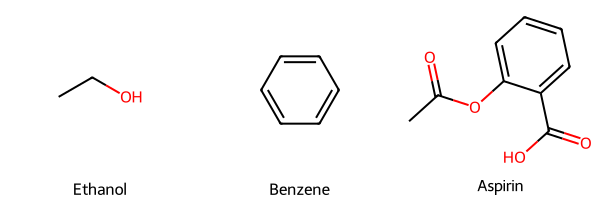

In [3]:
# Convert SMILES to RDKit molecules
smiles_mols = [Chem.MolFromSmiles(smi) for smi in smiles_examples.values()]
print("Small Molecules:")
Draw.MolsToGridImage(smiles_mols, molsPerRow=3, legends=list(smiles_examples.keys()))

**Visualizing Polymers (pSMILES)**  
Now, we visualize polymer repeat units using pSMILES. The dummy atoms (`[*]`) indicate where polymerization occurs.



Polymers (pSMILES):


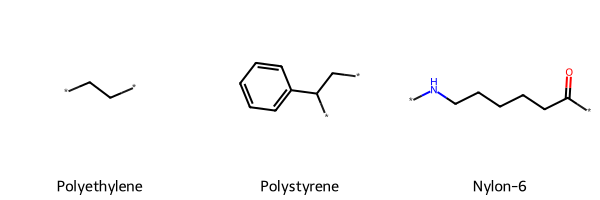

In [4]:
# Convert SMILES to RDKit molecules
psmiles_mols = [Chem.MolFromSmiles(smi.replace("[*]", "*")) for smi in psmiles_examples.values()]
print("\nPolymers (pSMILES):")
Draw.MolsToGridImage(psmiles_mols, molsPerRow=3, legends=list(psmiles_examples.keys()))

## Tokenizing pSMILES with polyBERT

### 1️⃣ Why Do We Need Tokenization?  
In Natural Language Processing (NLP), tokenization breaks text into smaller units (tokens) for model training. Similarly, for polymer informatics, we need to convert **pSMILES strings** into tokens before processing them with polyBERT.

### 2️⃣ How Does polyBERT Tokenize pSMILES?  
polyBERT follows a two-step process for tokenizing polymer SMILES (pSMILES):

#### **Step 1: Canonicalization**  
- pSMILES strings are first converted into a **canonical form** to maintain consistency.
- Example transformation: `[*]CCOCCO[*]` to `[*]COC[*]`
- This ensures that structurally identical polymers always have the same representation.

#### **Step 2: Tokenization Using SentencePiece**  
- polyBERT uses **SentencePiece**, a subword tokenizer, to split pSMILES into **265 unique tokens**.
- These tokens include:
- **Common chemical symbols** (e.g., elements like `C`, `O`, `N`, `H`)
- **Numerical digits** (`0-9`)
- **Special characters** (`[*]`, `(`, `)`, `=`, `.`)
- This approach ensures **full coverage of the polymer SMILES vocabulary**.

Now, we will **tokenize a sample pSMILES string** and examine how the tokenizer splits it into tokens.


In [5]:
from transformers import AutoTokenizer

# Load polyBERT tokenizer from Hugging Face
tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')

# Define sample pSMILES strings
psmiles_examples = [
    "[*]CC[*]",         # Polyethylene
    "[*]NCCCCCC(=O)[*]",        # Nylon-6
    "[*]CC(c1ccccc1)[*]" # Polystyrene
]

# Tokenize the pSMILES sequences
encoded_input = tokenizer(psmiles_examples, padding=True, truncation=True, return_tensors='pt')

# Display tokenized output
print("-" * 50)
for i, psmiles in enumerate(psmiles_examples):
    print(f"Original pSMILES: {psmiles}")
    print(f"Tokenized: {tokenizer.tokenize(psmiles)}")
    print(f"Token IDs: {encoded_input['input_ids'][i].tolist()}")
    print("-" * 50)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------------------------------------
Original pSMILES: [*]CC[*]
Tokenized: ['▁', '[*]', 'C', 'C', '[*]']
Token IDs: [265, 264, 5, 33, 33, 5, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267]
--------------------------------------------------
Original pSMILES: [*]NCCCCCC(=O)[*]
Tokenized: ['▁', '[*]', 'N', 'C', 'C', 'C', 'C', 'C', 'C', '(', '=', 'O', ')', '[*]']
Token IDs: [265, 264, 5, 34, 33, 33, 33, 33, 33, 33, 6, 8, 35, 7, 5, 266, 267]
--------------------------------------------------
Original pSMILES: [*]CC(c1ccccc1)[*]
Tokenized: ['▁', '[*]', 'C', 'C', '(', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', ')', '[*]']
Token IDs: [265, 264, 5, 33, 33, 6, 151, 12, 151, 151, 151, 151, 151, 12, 7, 5, 266]
--------------------------------------------------


### Exploring Tokenization in polyBERT

polyBERT uses **SentencePiece** to tokenize pSMILES, breaking them into subword units.  

🔹 **`_` (underscore)** appears at the start of the sequence as a [word boundary marker](https://github.com/huggingface/transformers/issues/5087).  
🔹 The tokenizer handles polymer-specific symbols like `[*]`, ensuring consistent representation.  

\\

🔍 **Explore Further**: Check the polyBERT tokenizer script:  
🔗 [polyBERT Tokenizer Code](https://github.com/Ramprasad-Group/polyBERT/blob/main/polyBERT/train_tokenizer.py)  

## Generating Polymer Fingerprints with polyBERT

Now that we have tokenized **pSMILES**, we need to generate **numerical representations (fingerprints)** for these sequences.

### 🔹 How Are Fingerprints Generated?  
- Each token from the **polyBERT tokenizer** is mapped to an **embedding**.
- Since polyBERT **does not use the `[CLS]` token**, we compute the final sequence representation using **mean pooling**.
- **Mean pooling** averages the token embeddings while considering the attention mask.

We will now generate and explore these **polymer fingerprints**.


In [6]:
from transformers import AutoTokenizer, AutoModel
import torch

# Function for Mean Pooling
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load polyBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
model = AutoModel.from_pretrained('kuelumbus/polyBERT')

# Define sample pSMILES strings
psmiles_examples = [
    "[*]CC[*]",         # Polyethylene
    "[*]NCCCCCC(=O)[*]",        # Nylon-6
    "[*]CC(c1ccccc1)[*]" # Polystyrene
]

# Tokenize input
encoded_input = tokenizer(psmiles_examples, padding=True, truncation=True, return_tensors="pt")

# Generate token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Compute fingerprints using mean pooling
fingerprints = mean_pooling(model_output, encoded_input['attention_mask'])

# Display results
print("Fingerprint vectors:")
print(fingerprints)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Fingerprint vectors:
tensor([[-0.1186,  0.1891, -0.5370,  ..., -0.8715,  0.2979,  0.6712],
        [ 0.4555,  0.3245,  0.3077,  ..., -0.2371,  0.1776, -0.0755],
        [ 0.6937,  0.1983,  0.5628,  ..., -0.3451,  0.2012,  1.1815]])


## Exploring the Fingerprints

Now that we have generated **polymer fingerprints**, explore the following:

🔹 **What is the shape of the fingerprints?**  Check `fingerprints.shape`.

🔹 **Does the tokenizer contain the `[CLS]` token?**  Try printing `tokenizer.cls_token`. What do you observe?

🔹 **How are embeddings generated without `[CLS]`?**  Since polyBERT does not rely on `[CLS]`, why does it use **mean pooling** instead?

💡 **Hint:** Mean pooling ensures that the final fingerprint represents the entire polymer sequence.

In [ ]:
# print("Fingerprint shape:", fingerprints.shape)

## Exploring the Relationship between Polymer Fingerprints and their Properties

Now that we have our dataset, we will generate **polymer fingerprints** using polyBERT.  

### Steps Involved
1️⃣ Load the dataset containing polymer SMILES and their **bandgap chain values (Egc)**.  
2️⃣ Tokenize each polymer SMILES and extract a fingerprint representation using polyBERT with mean pooling.  
3️⃣ Visualize the embeddings to see if they reflect polymer properties, specifically their bandgap (Egc) values.  

These embeddings capture structural and chemical information about each polymer, helping us understand the **relationship between polymer structure and electronic properties**.  

In [7]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from tqdm import tqdm

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
model = AutoModel.from_pretrained('kuelumbus/polyBERT').to(device)

# Load dataset
url = "https://github.com/ChangwenXu98/TransPolymer/raw/master/data/Egc.csv"
df = pd.read_csv(url)

# Extract pSMILES and property values
psmiles_list = df["smiles"].tolist()
property_values = df["value"].tolist()

Using device: cuda


In [8]:
# Define batch size
batch_size = 64  # Adjust this value based on your GPU memory capacity
fingerprints_list = []

# Process in batches
for i in tqdm(range(0, len(psmiles_list), batch_size), desc="Processing Batches"):
    batch_psmiles = psmiles_list[i:i+batch_size]  # Get batch
    encoded_input = tokenizer(batch_psmiles, padding=True, truncation=True, return_tensors="pt").to(device)  # Tokenize

    with torch.no_grad():
        model_output = model(**encoded_input)  # Get model output

    # Compute fingerprints using mean pooling
    fingerprints = mean_pooling(model_output, encoded_input['attention_mask'])

    # Move to CPU and store
    fingerprints_list.append(fingerprints.cpu().numpy())

Processing Batches: 100%|██████████| 53/53 [00:05<00:00,  9.84it/s]


In [9]:
# Concatenate all batches into a single array
fingerprints_np = np.vstack(fingerprints_list)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(fingerprints_np)

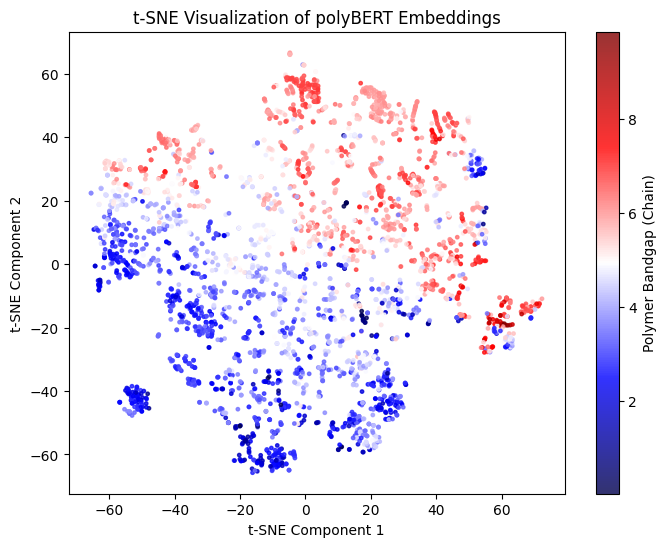

In [10]:
# Scatter plot with color mapping based on property value
plt.figure(figsize=(8, 6))
sc = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=property_values, cmap="seismic", alpha=0.8, s=6)
plt.colorbar(sc, label="Polymer Bandgap (Chain)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of polyBERT Embeddings")
plt.show()
